In [1]:
# Ensure we are in the correct dir if running this on google colab
try:
    from google.colab import drive

    drive.mount("/gdrive")
    
    # Change with your path
    root = '/gdrive/My Drive/Colab Notebooks/diplecs'

    import os
    os.chdir(root)
except:
    pass


In [8]:
import dataset as data

img_path, images, dat_files = data.get_paths()

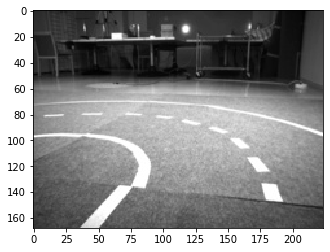

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from os import path

im = np.array(Image.open(images[0]))

plt.imshow(im, cmap='gray')
plt.show()

In [10]:
import pandas as pd

df = pd.read_csv(dat_files[0], sep='\t', names=["image", "throttle", "steering"])

df = data.normalize_df(df)
df.describe()

,throttle,steering
count,2930.000000,2930.000000
mean,0.707896,0.232195
std,0.121652,0.286006
min,0.000000,0.000000
25%,0.711581,0.000000
50%,0.730809,0.019203
75%,0.750037,0.499287
max,1.000000,1.000000


In [11]:
df = data.read_dataset(dat_files)

df.describe()
print("hi")

hi


In [12]:
import torch
import torch.nn
from torch.utils.data import Dataset
from skimage import io, color

cuda = torch.device('cuda')

# This will implement the Dataset class for our Image Dataset
class ImageDataset(Dataset):
    def __init__(self, dat_files, root_dir, limit=None, transform=None):
        self.df = dataset_to_df(dat_files)

        if limit is not None:
          self.df = self.df.iloc[:limit]

        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        img_name = path.join(self.root_dir, self.df.iloc[idx, 0])
        
        # convert into RGB to suppors transfer learning using the Resnet
        image = color.gray2rgb(io.imread(img_name))
        feats = self.df.iloc[idx, 1:]
        feats = np.array([feats]).astype('float').reshape(-1, 2)
        
        sample = {'image': image, 'feats': feats}
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample

In [21]:
dataset = data.ImageDataset(df, img_path, limit=2000)

# Try the length function
print(len(dataset))

# And try to access some elements
print(dataset[0])
print(dataset[-1])

2000
{'image': array([[[121, 121, 121],
        [122, 122, 122],
        [124, 124, 124],
        ...,
        [144, 144, 144],
        [142, 142, 142],
        [141, 141, 141]],

       [[121, 121, 121],
        [122, 122, 122],
        [124, 124, 124],
        ...,
        [144, 144, 144],
        [143, 143, 143],
        [141, 141, 141]],

       [[122, 122, 122],
        [123, 123, 123],
        [124, 124, 124],
        ...,
        [144, 144, 144],
        [143, 143, 143],
        [142, 142, 142]],

       ...,

       [[ 50,  50,  50],
        [ 55,  55,  55],
        [ 52,  52,  52],
        ...,
        [ 61,  61,  61],
        [ 67,  67,  67],
        [ 77,  77,  77]],

       [[ 46,  46,  46],
        [ 51,  51,  51],
        [ 51,  51,  51],
        ...,
        [ 66,  66,  66],
        [ 67,  67,  67],
        [ 73,  73,  73]],

       [[ 46,  46,  46],
        [ 48,  48,  48],
        [ 47,  47,  47],
        ...,
        [ 72,  72,  72],
        [ 67,  67,  67],
        [

0 (168, 224, 3) (1, 2)
1 (168, 224, 3) (1, 2)
2 (168, 224, 3) (1, 2)


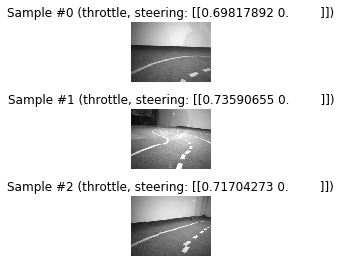

In [22]:
fig = plt.figure()

def plot_dataset(dataset):
    for i, idx in enumerate([500, 1000, 1500]):
        sample = dataset[idx]

        print(i, sample['image'].shape, sample['feats'].shape)

        ax = plt.subplot(3, 1, i + 1)
        plt.tight_layout()
        ax.set_title(f"Sample #{i} (throttle, steering: {sample['feats']})")
        ax.axis('off')
        plt.imshow(sample['image'], cmap='gray')

        if i == 2:
            plt.show()
            break
            
plot_dataset(dataset)

In [24]:
from torch.utils.data import DataLoader

dataset = data.ImageDataset(df, img_path, limit=5000, transform=data.to_tensor)
dataloader = DataLoader(dataset, batch_size=50, shuffle=True, num_workers=4)

In [39]:
from torchvision import models
from torch import nn, optim

model = models.resnet50(pretrained=True)

# Change the last layer to compute steering and throttle
# Add a sigmoid to ensure that the result will be in (0, 1)
model.fc = nn.Sequential(nn.Linear(model.fc.in_features, 2), nn.Sigmoid())

device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
    model.cuda()

criterion = nn.MSELoss()

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [40]:
import training

trained = training.train(model, dataloader, criterion, optimizer, device, epochs=5)

Epoch 0/4
----------


KeyboardInterrupt: 

In [42]:
sample = dataloader.dataset[1]
feats = sample['feats']
image = sample['image'].to(device).view(1, 3, 168, 224)

traine
predicted = trained(image)

print("Predicted", predicted)
print("feats", feats)

NameError: name 'trained' is not defined